# Imports

Need to have jate.py in your folder

In [1]:
%run jate.py #will import everything

# Next chapter

## memory clear (uses regex, so be careful)

In [2]:
%reset_selective -f var1, var2  # replace var1, var2 with your defined ones

## Building parts

### Building the things to be calculated only once

In [3]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constant of the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [4]:
omega_1 = 0.5
H_0 = omega_1*sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
gamma = 0.1 # check for default value
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=gamma)

In [5]:
gamma

0.1

In [6]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [7]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [8]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -1.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   1.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [9]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [10]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949837e-04-2.49966628e-07j
  -4.99949837e-04+2.49966628e-07j  2.49983293e-07+0.00000000e+00j]
 [ 4.99949837e-04+2.49966628e-07j  9.99799270e-01+9.99799687e-04j
  -2.49966628e-07+0.00000000e+00j -4.99949837e-04-2.49966628e-07j]
 [ 4.99949837e-04-2.49966628e-07j -2.49966628e-07+0.00000000e+00j
   9.99799270e-01-9.99799687e-04j -4.99949837e-04+2.49966628e-07j]
 [ 2.49983293e-07+0.00000000e+00j  4.99949837e-04+2.49966628e-07j
   4.99949837e-04-2.49966628e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [11]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [12]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [13]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [14]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [15]:
fidelity_calc(sigmax(), sigmay())

4.0

In [16]:
fidelity_calc(sigmay(), sigmay())

0.0

In [17]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [18]:
xi_vec_test.size

2

In [19]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [20]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634493138

In [21]:
L_v = L_vec(xi_vec_test, 0.001)

In [22]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99899173e-04-4.99933130e-07j
   -9.99899173e-04+4.99933130e-07j  9.99932920e-07+0.00000000e+00j]
  [ 9.99899173e-04+4.99933130e-07j  9.99798520e-01+9.99799187e-04j
   -9.99866260e-07+0.00000000e+00j -9.99899173e-04-4.99933130e-07j]
  [ 9.99899173e-04-4.99933130e-07j -9.99866260e-07+0.00000000e+00j
    9.99798520e-01-9.99799187e-04j -9.99899173e-04+4.99933130e-07j]
  [ 9.99932920e-07+0.00000000e+00j  9.99899173e-04+4.99933130e-07j
    9.99899173e-04-4.99933130e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979435e-03-9.99865260e-07j
   -1.99979435e-03+9.99865260e-07j  3.99972768e-06+0.00000000e+00j]
  [ 1.99979435e-03+9.99865260e-07j  9.99795521e-01+9.99797187e-04j
   -3.99946104e-06+0.00000000e+00j -1.99979435e-03-9.99865

### Major Functions 2

In [23]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [24]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927960e-03-3.49898670e-06j
  -2.99927960e-03+3.49898670e-06j  8.99883703e-06+0.00000000e+00j]
 [ 2.99948056e-03+2.49939255e-06j  9.99589083e-01+1.99918650e-03j
  -8.99750347e-06+2.99899242e-09j -2.99948056e-03-2.49939255e-06j]
 [ 2.99948056e-03-2.49939255e-06j -8.99750347e-06-2.99899242e-09j
   9.99589083e-01-1.99918650e-03j -2.99948056e-03+2.49939255e-06j]
 [ 8.99883703e-06+0.00000000e+00j  2.99927960e-03+3.49898670e-06j
   2.99927960e-03-3.49898670e-06j  9.99991001e-01+0.00000000e+00j]]

In [25]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [26]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

## Qutip grape for closed system

In [27]:
import time

In [28]:
total_time_evo = 2*pi # total time allowed for evolution

In [29]:
times = linspace(0, total_time_evo, 500) 

In [30]:
# vector of times at which discretization 
# is carried out

In [31]:
U = T_s
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [32]:
R = 500

In [33]:
H_ops = [H_1]
H_ops

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]]]

In [34]:
H_labels = [r'$g_{no diss}$']
H_labels

['$g_{no diss}$']

In [35]:
H0 = H_0
H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]

In [36]:
c_ops = []

In [37]:
from qutip.control.grape import plot_grape_control_fields, _overlap 
from qutip.control.grape import grape_unitary_adaptive, cy_grape_unitary

In [38]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar, EnhancedTextProgressBar

In [39]:
u0 = array([rand(len(times)) * 2 * pi * 0.05 for _ in range(len(H_ops))])

In [40]:
from numpy import convolve
u0 = [convolve(ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [41]:
u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [42]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:  33.41s. Est. time left: 00:00:05:00
20.0%. Run time:  67.28s. Est. time left: 00:00:04:29
30.0%. Run time:  99.59s. Est. time left: 00:00:03:52
40.0%. Run time: 131.88s. Est. time left: 00:00:03:17
50.0%. Run time: 164.22s. Est. time left: 00:00:02:44
60.0%. Run time: 196.30s. Est. time left: 00:00:02:10
70.0%. Run time: 228.43s. Est. time left: 00:00:01:37
80.0%. Run time: 260.48s. Est. time left: 00:00:01:05
90.0%. Run time: 294.69s. Est. time left: 00:00:00:32
Total run time: 326.33s


#### Plot of optimized control field without dissipation

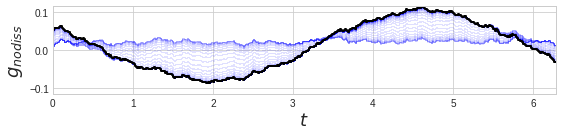

In [43]:
plot_grape_control_fields(times,
                          result.u / (2 * np.pi), H_labels, uniform_axes=True);

In [44]:
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [45]:
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 5.49998821e-16+1.60461922e-17j  2.94609264e-16-1.00000000e+00j]
 [-9.95309563e-16-1.00000000e+00j -8.54683349e-16+1.27068495e-16j]]

## Analysis of result of qutip grape for closed system

In [46]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -5.30003779e+13-1.81663943e+15j]
 [-5.30003779e+13-1.81663943e+15j -1.54591679e+00+2.76136178e-01j]]

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f93be2af400>)

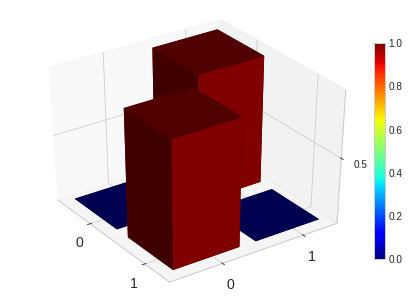

In [47]:
matrix_histogram(U)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f93be1d4208>)

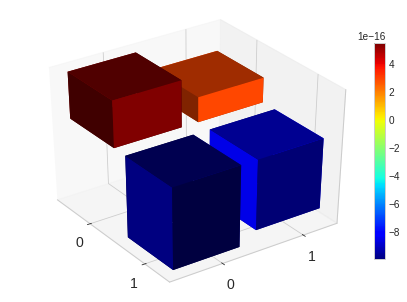

In [48]:
matrix_histogram(result.U_f)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f93be14f4e0>)

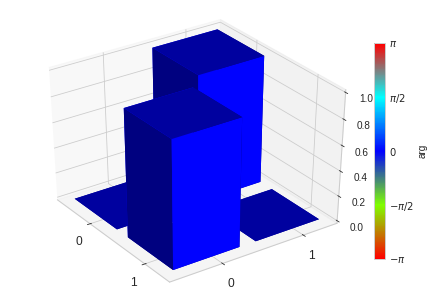

In [49]:
matrix_histogram_complex(U)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f93be11ee10>)

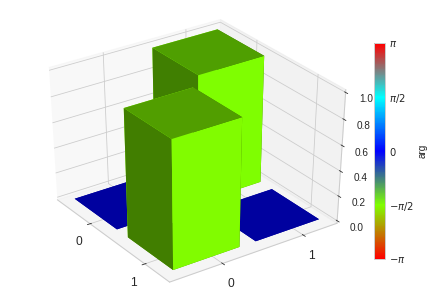

In [50]:
matrix_histogram_complex(result.U_f)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93bdfc1fd0>)

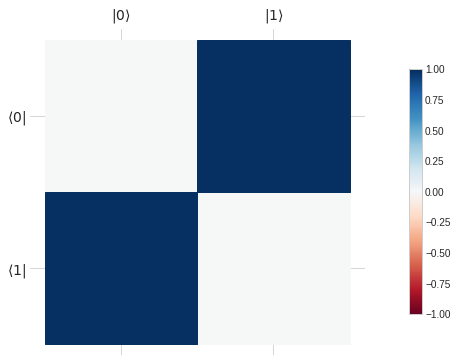

In [51]:
hinton(U)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93bdf67f98>)

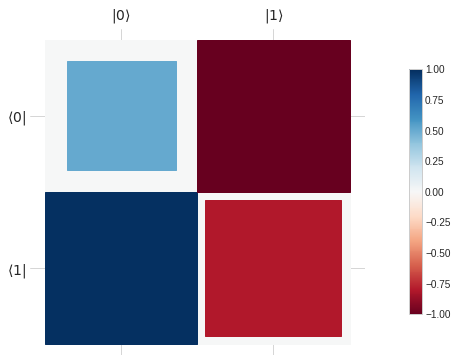

In [52]:
hinton(result.U_f)

In [53]:
updater(result.u[-1, 0, : ] , (2*pi)/500, epsilon=((0.1*2*pi)/(10**3)))

(array([-0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j, -0.00207613+0.j,
        -0.0

In [54]:
times[-1]

6.283185307179586

In [55]:
total_time_evo

6.283185307179586

## joining qutip to my code

##### total_time
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-55-9bec417112c8> in <module>()
----> 1 total_time

NameError: name 'total_time' is not defined


In [56]:
len(times)

500

def terminator(max_iter, time_steps=len(times), total_time= total_time_evo,
               epsilon= 2*pi*1):
    r"""Brief description of the function"""
    
    xi_initial = result.u[-1, 0, : ] 
    #1000*random_sample((time_steps,))
    dt = (2*pi)/500  #total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

In [57]:
def terminator(max_iter, time_steps=len(times),
              total_time=total_time_evo,
              epsilon=2*pi*1):
    r"""Brief description of the function"""
    xi_initial = result.u[-1, 0, :]
    # 1000*random_sample((time_steps,))
    dt = (2*pi)/500 #total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    min_iter = int(max_iter/2)
    for i in range(max_iter):
        if i == 0:
            print("Hi")
            
        
        if i > min_iter :
            
            if i > min_iter + 1 :
                print("Surpassed minimum iteration barrier")
            if amax(xi_diff) < epsilon**2 :
                xi_final = xi_new_vec
                #print("Tejas is unlucky")
                print("Attempted iterations ", i)
                break
            else :
                xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
                #print("Tejas is a good boy")
                print(i)
                print(amax(xi_diff))
        
        else :
            #print("Normal life")    
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
    return xi_final


## sub topic 3

In [58]:
new_label = [r'$g_{with diss}$']

### try

In [59]:
xi_opt = terminator(10)

Hi
0
(-41.30117088126254+0j)
1
(-41.27381629787922+0j)
2
(-41.27511764368741+0j)
3
(-41.27750316853387+0j)
4
(-41.27320045060356+0j)
5
(-41.27818536892015+0j)
Attempted iterations  6


In [60]:
time_steps=len(times)
total_time= total_time_evo
epsilon= 2*pi*1

In [61]:
dt = (2*pi)/500
F(xi_opt, dt)

-4.219049970380669

In [62]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.45230997+0.00000000e+00j -0.26245401+3.53272532e-04j
  -0.26245401-3.53272532e-04j  0.54769003+0.00000000e+00j]
 [ 0.26245399-3.54157943e-04j  0.09471193-9.77811602e-04j
  -0.18989754+1.65650098e-06j -0.26245399+3.54157943e-04j]
 [ 0.26245399+3.54157943e-04j -0.18989754-1.65650098e-06j
   0.09471193+9.77811602e-04j -0.26245399-3.54157943e-04j]
 [ 0.54769003+0.00000000e+00j  0.26245401-3.53272532e-04j
   0.26245401+3.53272532e-04j  0.45230997+0.00000000e+00j]]

/home/tejas/anaconda3/envs/qutip-env/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tejas/anaconda3/envs/qutip-env/lib/python3.6/site-packages/matplotlib/transforms.py:968: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


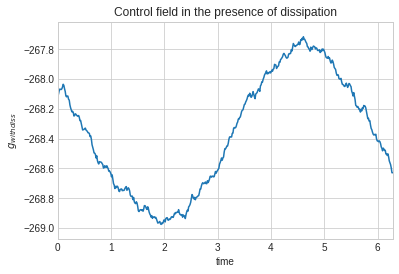

In [63]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [64]:
xi_opt = terminator(1000)

Hi
0
(-41.30117088126254+0j)
1
(-41.27381629787922+0j)
2
(-41.27511764368741+0j)
3
(-41.27750316853387+0j)
4
(-41.27320045060356+0j)
5
(-41.27818536892015+0j)
6
(-41.27317632735506+0j)
7
(-41.27778408036589+0j)
8
(-41.273917844358266+0j)
9
(-41.276866807220905+0j)
10
(-41.274921417802204+0j)
11
(-41.275852421726185+0j)
12
(-41.27583645310008+0j)
13
(-41.27506027434989+0j)
14
(-41.27642955065619+0j)
15
(-41.27467393097016+0j)
16
(-41.27659989356431+0j)
17
(-41.27471497852044+0j)
18
(-41.27638531306426+0j)
19
(-41.27507287527054+0j)
20
(-41.27593531862958+0j)
21
(-41.27556170647555+0j)
22
(-41.27544992333113+0j)
23
(-41.27598955181517+0j)
24
(-41.27510805871702+0j)
25
(-41.276216088798144+0j)
26
(-41.27500930266141+0j)
27
(-41.2761900363144+0j)
28
(-41.27515281823597+0j)
29
(-41.27595490210073+0j)
30
(-41.2754519305058+0j)
31
(-41.275623717078524+0j)
32
(-41.27577749838867+0j)
33
(-41.2753313333146+0j)
34
(-41.27600698448428+0j)
35
(-41.2751822176336+0j)
36
(-41.276066092135146+0j)
37
(-

295
(-41.27563015865653+0j)
296
(-41.27559496546702+0j)
297
(-41.27566053936528+0j)
298
(-41.27557149605902+0j)
299
(-41.27567473576749+0j)
300
(-41.27556798439604+0j)
301
(-41.275667311577386+0j)
302
(-41.27558555037337+0j)
303
(-41.27564149236707+0j)
304
(-41.27561692302436+0j)
305
(-41.2756077932927+0j)
306
(-41.275649446857436+0j)
307
(-41.27557973265099+0j)
308
(-41.275670179344566+0j)
309
(-41.275568405158566+0j)
310
(-41.27567102331797+0j)
311
(-41.27557809708235+0j)
312
(-41.275651888338565+0j)
313
(-41.27560467261462+0j)
314
(-41.27562063694333+0j)
315
(-41.27563734338438+0j)
316
(-41.27558986524449+0j)
317
(-41.27566304536457+0j)
318
(-41.2755718200535+0j)
319
(-41.27567164025943+0j)
320
(-41.27557352235394+0j)
321
(-41.27565991562888+0j)
322
(-41.27559403584711+0j)
323
(-41.27563277939486+0j)
324
(-41.27562496299199+0j)
325
(-41.275601224382456+0j)
326
(-41.275653875358564+0j)
327
(-41.2755778728992+0j)
328
(-41.27566929737103+0j)
329
(-41.27557192203541+0j)
330
(-41.2756652

In [65]:
time_steps=len(times)
total_time= total_time_evo
epsilon= 2*pi*1

In [66]:
dt = (2*pi)/500
F(xi_opt, dt)

-4.219438201331842

In [67]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.26860643+0.00000000e+00j -0.13270097+9.02661703e-06j
  -0.13270097-9.02661703e-06j  0.73139357+0.00000000e+00j]
 [ 0.13270097-9.02656244e-06j -0.08908816-6.41081955e-06j
  -0.37369771+6.77637638e-11j -0.13270097+9.02656244e-06j]
 [ 0.13270097+9.02656244e-06j -0.37369771-6.77637650e-11j
  -0.08908816+6.41081955e-06j -0.13270097-9.02656244e-06j]
 [ 0.73139357+0.00000000e+00j  0.13270097-9.02661703e-06j
   0.13270097+9.02661703e-06j  0.26860643+0.00000000e+00j]]

/home/tejas/anaconda3/envs/qutip-env/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tejas/anaconda3/envs/qutip-env/lib/python3.6/site-packages/matplotlib/transforms.py:968: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


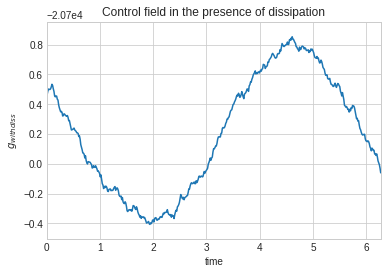

In [68]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(times[-1])))

Hi
0
(-0.4571045443570439+0j)
1
(-0.7232345261942117+0j)
2
(-0.6651785575847724+0j)
3
(-0.6657926571118615+0j)
4
(-0.6569079717013682+0j)
5
(-0.6567650441007232+0j)
6
(-0.6605889590292744+0j)
7
(-0.6574390800143084+0j)
8
(-0.6558851842025688+0j)
9
(-0.6587849143026541+0j)
10
(-0.6578088158649859+0j)
11
(-0.6558310260550814+0j)
12
(-0.6577883792279144+0j)
13
(-0.6579602105422354+0j)
14
(-0.6560718338285085+0j)
15
(-0.6571640686327712+0j)
16
(-0.6579614590330518+0j)
17
(-0.656348736084635+0j)
18
(-0.6567749124697024+0j)
19
(-0.657870649153663+0j)
20
(-0.6566521300661731+0j)
21
(-0.656530645550628+0j)
22
(-0.657702824591559+0j)
23
(-0.6569167276689452+0j)
24
(-0.6564005505920196+0j)
25
(-0.6574823491881572+0j)
26
(-0.6571399050707316+0j)
27
(-0.6563851341982101+0j)
28
(-0.6572554522049496+0j)
29
(-0.6573081712538067+0j)
30
(-0.6564389829834735+0j)
31
(-0.6570324942334133+0j)
32
(-0.6573882343276725+0j)
33
(-0.6565646738057156+0j)
34
(-0.6568503922434517+0j)
35
(-0.6574064892462403+0j)
36


In [ ]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(10,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(times[-1])))

In [ ]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [ ]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
F(result.u[-1, 0, : ], dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
len(times)

In [ ]:
new_label = [r'$g_{with diss}$']

'''plot_grape_control_fields(times,
                          xi_opt / (2 * np.pi), new_label, uniform_axes=True);
ValueError                                Traceback (most recent call last)
<ipython-input-67-f3ebb7c23258> in <module>()
      1 plot_grape_control_fields(times,
----> 2                           xi_opt / (2 * np.pi), new_label, uniform_axes=True);

/anaconda3/envs/qutip-env/lib/python3.6/site-packages/qutip/control/grape.py in plot_grape_control_fields(times, u, labels, uniform_axes)
    101     import matplotlib.pyplot as plt
    102 
--> 103     R, J, M = u.shape
    104 
    105     fig, axes = plt.subplots(J, 1, figsize=(8, 2 * J), squeeze=False)

ValueError: not enough values to unpack (expected 3, got 1) '''

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
ax.set(xlim=(0, total_time_evo), ylim=(-0.8,0.8 ),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

In [ ]:
ax = axes()
ax.plot(times, result.u[-1, 0, : ])
xi_max = amax(result.u[-1, 0, : ]) + 0.1
xi_min = amin(result.u[-1, 0, : ]) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='old Control field in the presence of \
              dissipation produced by qutip');

### try

In [ ]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**4)))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**4)))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**10)))

In [ ]:
dt = (2*pi)/500
F(xi_opt, dt)

In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

### try

In [ ]:
xi_opt = terminator(10**4,time_steps=10**3, total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [ ]:
dt = (2*pi)/(10**3)#(2*pi)/500
# probaly happened because of hard coding of dt inside terminator
# must try it again after changing that
F(xi_opt, dt)


In [ ]:
L_full_maker(xi_opt, dt)

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

## APS stuff

### infidelity function tryouts

In [ ]:
qone = basis(2, 0)
qone

In [ ]:
qzero = basis(2, 1)
qzero

###### ket2bra
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-69-8f247c0c4d8f> in <module>()
----> 1 ket2bra

NameError: name 'ket2bra' is not defined


In [ ]:
(sigmax()).matrix_element(qone, qzero)

In [ ]:
abs((sigmax()).matrix_element(qone, qzero))

In [ ]:
abs(2 + 3j)

In [ ]:
abs(3 + 4j)

In [ ]:
def infidelity_to_one(U):
    r"""infidelity to state one"""
    fidelity = (abs(U.matrix_element(qone, qzero)))**2
    infidelity = 1 - fidelity
    return infidelity

In [ ]:
infidelity_to_one(sigmax()) 
# 1 - abs((sigmax()).matrix_element(qone, qzero))
# 1 - 1 = 0

  result.u, result.u but lindbladian evolution, xi_opt

In [ ]:
qone.overlap(qzero)

In [ ]:
qzero.overlap(qzero)

In [ ]:
qone.overlap(qone)

In [ ]:
def infidelity_to_state(psi):
    r"""infidelity to state one"""
    fidelity = (abs(qone.overlap(psi)))**2
    infidelity = 1 - fidelity
    return infidelity

In [ ]:
infidelity_to_state(qzero)

In [ ]:
infidelity_to_state(qone)

In [ ]:
#mesolve


### state building

In [ ]:
H_no_diss = [H_0, [H_1, result.u[-1, 0, :] ]]
grape_no_diss = mesolve(H_no_diss, qzero, times, c_ops=[], e_ops=[], 
                        args={}, options=None, 
                        progress_bar=EnhancedTextProgressBar() )

In [ ]:
len(grape_no_diss.states)

In [ ]:
Lin

In [ ]:
sqrt(gamma)

In [ ]:
c_ops_tejas = sqrt(gamma)*Lin
c_ops_tejas

In [ ]:
H_diss = [H_0, [H_1, result.u[-1, 0, :] ]]
grape_diss = mesolve(H_no_diss, qzero, times, c_ops=[c_ops_tejas], e_ops=[], 
                        args={}, options=None, 
                        progress_bar=EnhancedTextProgressBar() )

In [ ]:
len(grape_diss.states)

In [ ]:
H_diss_optimized = [H_0, [H_1, xi_opt ]]
grape_diss_optimized = mesolve(H_diss_optimized, qzero, times, c_ops=[c_ops_tejas], 
                               e_ops=[], args={}, options=None, 
                               progress_bar=TextProgressBar() )
# H_diss_optimized should have been written isntead of H_no_diss

In [ ]:
len(grape_diss_optimized.states)

### states list to fidelity list

In [ ]:
infidelity_to_state_vec = vectorize(infidelity_to_state)

In [ ]:
infid_grape_no_diss = infidelity_to_state_vec(grape_no_diss.states)

In [ ]:
'''fid_grape_diss = infidelity_to_state_vec(grape_diss.states)
TypeError                                 Traceback (most recent call last)
<ipython-input-101-fbabc06eff84> in <module>()
----> 1 fid_grape_diss = infidelity_to_state_vec(grape_diss.states)

/anaconda3/envs/qutip-env/lib/python3.6/site-packages/numpy/lib/function_base.py in __call__(self, *args, **kwargs)
   2753             vargs.extend([kwargs[_n] for _n in names])
   2754 
-> 2755         return self._vectorize_call(func=func, args=vargs)
   2756 
   2757     def _get_ufunc_and_otypes(self, func, args):

/anaconda3/envs/qutip-env/lib/python3.6/site-packages/numpy/lib/function_base.py in _vectorize_call(self, func, args)
   2823             res = func()
   2824         else:
-> 2825             ufunc, otypes = self._get_ufunc_and_otypes(func=func, args=args)
   2826 
   2827             # Convert args to object arrays first

/anaconda3/envs/qutip-env/lib/python3.6/site-packages/numpy/lib/function_base.py in _get_ufunc_and_otypes(self, func, args)
   2783 
   2784             inputs = [arg.flat[0] for arg in args]
-> 2785             outputs = func(*inputs)
   2786 
   2787             # Performance note: profiling indicates that -- for simple

<ipython-input-96-32321f8d8a33> in infidelity_to_state(psi)
      1 def infidelity_to_state(psi):
      2     r"""infidelity to state one"""
----> 3     fidelity = (abs(qone.overlap(psi)))**2
      4     infidelity = 1 - fidelity
      5     return infidelity

/anaconda3/envs/qutip-env/lib/python3.6/site-packages/qutip/qobj.py in overlap(self, state)
   1486                     return (self.data.H * state.data)[0, 0]
   1487 
-> 1488         raise TypeError("Can only calculate overlap for state vector Qobjs")
   1489 
   1490     def eigenstates(self, sparse=False, sort='low',

TypeError: Can only calculate overlap for state vector Qobjs


'''

fid_grape_no_diss = infidelity_to_state_vec(grape_no_diss.states)

In [ ]:
fidelity(sigmax(), sigmax())

In [ ]:
zero_dm = ket2dm(qzero)
zero_dm

In [ ]:
one_dm = ket2dm(qone)
one_dm

In [ ]:
fidelity(zero_dm, zero_dm)

In [ ]:
fidelity(zero_dm, one_dm)

In [ ]:
fidelity(one_dm, zero_dm)

In [ ]:
grape_no_diss.states[5]

In [ ]:
grape_diss.states[5]

In [ ]:
grape_diss.states[7]

In [ ]:
fidelity(grape_diss.states[7], one_dm)

In [ ]:
#0.012−2.347×10**−05j)

In [ ]:
def infidelity_tejas(dm, d=2):
    r"""Brief description of the function"""
    infid = 1 - fidelity(one_dm, dm)
    return infid

In [ ]:
infid_dm_vec = vectorize(infidelity_tejas)

In [ ]:
infid_grape_diss = infid_dm_vec(grape_diss.states) 

In [ ]:
len(infid_grape_diss)

In [ ]:
infid_grape_diss_optimized = infid_dm_vec(grape_diss_optimized.states) 

In [ ]:
len(infid_grape_diss_optimized)

### plots

In [ ]:
ax = axes()
ax.plot(times, infid_grape_no_diss, label='grape_no_diss')
ax.plot(times, infid_grape_diss, label='grape_diss')
ax.plot(times, infid_grape_diss_optimized, label='grape_diss_optimized')
#ax.plot(x, cos(x), ':b', label='cos(x)')'-g',
#ax.axis('equal')
ax.legend()
ax.set(xlim=(times[0],times[-1]), ylim=(0, 1.1),
       xlabel='time', ylabel='Infidelity',
       title='Infidelity as a function of time ');

In [ ]:
ax = axes()
ax.plot(times, infid_grape_no_diss, label='grape_no_diss')
ax.plot(times, infid_grape_diss, label='grape_diss')
#ax.plot(times, infid_grape_diss_optimized, label='grape_diss_optimized')
#ax.plot(x, cos(x), ':b', label='cos(x)')'-g',
#ax.axis('equal')
ax.legend()

ax.set(xlim=(times[0],times[-1]), ylim=(0, 1.1),
       xlabel='time', ylabel='Infidelity',
       title='Infidelity as a function of time ');

In [ ]:
ax = axes()
ax.plot(times, infid_grape_no_diss, label='grape_no_diss')
#ax.plot(times, infid_grape_diss, label='grape_diss')
ax.plot(times, infid_grape_diss_optimized, label='grape_diss_optimized')
#ax.plot(x, cos(x), ':b', label='cos(x)')'-g',
#ax.axis('equal')
ax.legend()

ax.set(xlim=(times[0],times[-1]), ylim=(0, 1.1),
       xlabel='time', ylabel='Infidelity',
       title='Infidelity as a function of time ');

In [ ]:
ax = axes()
c_diff = result.u[-1, 0, : ] - xi_opt
ax.plot(times, c_diff)
c_max = amax(c_diff) + 0.1
c_min = amin(c_diff) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(c_min, c_max),
       xlabel='time', ylabel= 'diff',
       title='difference');

In [ ]:
ax = axes()
ax.plot(times, xi_opt)
xi_max = amax(xi_opt) + 0.1
xi_min = amin(xi_opt) - 0.1

ax.set(xlim=(0, total_time_evo), ylim=(xi_min, xi_max),
       xlabel='time', ylabel= r'$g_{with diss}$',
       title='Control field in the presence of dissipation');

## Integrated APS stuff

In [ ]:
def cF2p(Q_G, tejas_c):
    r"""Takes in the 2 control fields and produces the plot directly.
    The plot contains the following lines:
    1. Qutip grape without dissipation
    2. Qutip grape with dissipation
    3. My  control field with dissipation  
    Does some stuff.
    
    Parameters
    ----------
    Q_G     : numpy array? 
              control field Qutip grape without dissipation
         
    tejas_c : numpy array? 
              My  control field with dissipation for open quantum system
    
    
    Returns
    -------
    inFidelity vector for 
    1. Qutip grape without dissipation    : infid_grape_no_diss
    2. Qutip grape with dissipation       : infid_grape_diss 
    3. My  control field with dissipation : infid_grape_diss_optimized
    
    
    """
    qone = basis(2, 0)
    qzero = basis(2, 1)
    c_ops_tejas = sqrt(gamma)*Lin
    # state list building
    H_qutip = [H_0, [H_1, Q_G]] #result.u[-1, 0, :]
    print("grape_no_diss")
    grape_no_diss = mesolve(H_qutip, qzero, times, c_ops=[], 
                            e_ops=[], args={}, options=None, 
                            progress_bar=TextProgressBar() )
    print("")
    print("grape_diss")
    grape_diss = mesolve(H_qutip, qzero, times, c_ops=[c_ops_tejas], 
                         e_ops=[], args={}, options=None, 
                         progress_bar=TextProgressBar() )
    print("")
    print("grape_diss_optimized")
    H_diss_optimized = [H_0, [H_1, tejas_c ]]
    grape_diss_optimized = mesolve(H_diss_optimized, qzero, times, 
                                   c_ops=[c_ops_tejas], e_ops=[], 
                                   args={}, options=None,
                                   progress_bar=TextProgressBar() )
    # H_diss_optimized should have been written isntead of H_no_diss
    print("")
    print("")
    
    # states list to fidelity list
    one_dm = ket2dm(qone)
    zero_dm = ket2dm(qzero)
    def infidelity_tejas(dm, d=2):
        r"""Brief description of the function"""
        infid = 1 - fidelity(one_dm, dm)
        return infid
    
    infid_dm_vec = vectorize(infidelity_tejas)
    infid_grape_no_diss = infid_dm_vec(grape_no_diss.states) 
    infid_grape_diss = infid_dm_vec(grape_diss.states) 
    infid_grape_diss_optimized = infid_dm_vec(grape_diss_optimized.states) 
    list_of_infid_vec = [infid_grape_no_diss, infid_grape_diss, 
                         infid_grape_diss_optimized]
    return list_of_infid_vec

In [ ]:
#infid_grape_no_diss, infid_grape_diss, infid_grape_diss_optimized = \
#list_of_infid_vec = cF2p(Q_G, tejas_c) 
list_of_infid_vec = cF2p(result.u[-1, 0, :], xi_opt)                                                    

In [ ]:
ax = axes()
ax.plot(times, list_of_infid_vec[0], label='grape_no_diss')
ax.plot(times, list_of_infid_vec[1], label='grape_diss')
ax.plot(times, list_of_infid_vec[2], label='grape_diss_optimized')
#ax.plot(x, cos(x), ':b', label='cos(x)')'-g',
#ax.axis('equal')
ax.legend()
ax.set(xlim=(times[0],times[-1]), ylim=(0, 1.1),
       xlabel='time', ylabel='Infidelity',
       title='Infidelity as a function of time ');

## Versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()

In [ ]:
cnot()